In [45]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


def preprocess_train_df(csv_path, vote_bins=50, clip_max=100):
    df = pd.read_csv(csv_path)
    targets = df.columns[-6:]
    print("Train shape:", df.shape)
    print("Targets", list(targets))
    train = df.groupby("eeg_id")[
        ["spectrogram_id", "spectrogram_label_offset_seconds"]
    ].agg({"spectrogram_id": "first", "spectrogram_label_offset_seconds": "min"})
    train.columns = ["spec_id", "min"]

    tmp = df.groupby("eeg_id")[
        ["spectrogram_id", "spectrogram_label_offset_seconds"]
    ].agg({"spectrogram_label_offset_seconds": "max"})
    train["max"] = tmp
    tmp = df.groupby("eeg_id")[["patient_id"]].agg("first")
    train["patient_id"] = tmp
    tmp = df.groupby("eeg_id")[targets].agg("sum")
    for t in targets:
        train[t] = tmp[t].values
    y_data = train[targets].values
    vote_count = y_data.sum(axis=1)
    y_data = y_data / y_data.sum(axis=1, keepdims=True)
    train[targets] = y_data
    tmp = df.groupby("eeg_id")[["expert_consensus"]].agg("first")
    train["target"] = tmp
    train["vote_count"] = vote_count
    train["vote_count"].clip(0, clip_max, inplace=True)
    # hist, edges = np.histogram(train["vote_count"].to_numpy(), bins=50, range=(0, 100))
    vote_count_dict = {}
    for i in range(0, clip_max + 1):
        vote_count_dict[i] = i // (clip_max // vote_bins)
    train["vote_category"] = train["vote_count"].map(lambda x: vote_count_dict[x])
    train = train.reset_index()
    print("Train non-overlapp eeg_id shape:", train.shape)
    train.head()
    return train, targets

2

In [63]:
train["vote_category"]

0        24
1        50
2         1
3         0
4         1
         ..
17084     1
17085     1
17086     0
17087    37
17088     1
Name: vote_category, Length: 17089, dtype: int64

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
Train non-overlapp eeg_id shape: (17089, 13)


<BarContainer object of 50 artists>

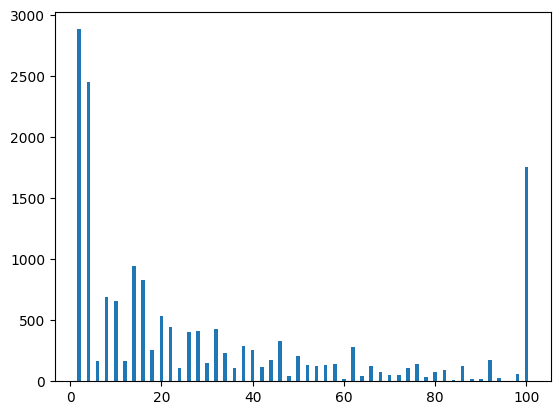

In [58]:
csv_path = "../input/hms-harmful-brain-activity-classification/train.csv"
train, targets = preprocess_train_df(csv_path)


hist, edges = np.histogram(train["vote_count"].to_numpy(), bins=50, range=(0, 100))
plt.bar(edges[1:], hist)

(array([2884., 2451.,  170.,  687.,  656.,  167.,  941.,  833.,  254.,
         533.,  446.,  106.,  406.,  416.,  151.,  429.,  228.,  106.,
         288.,  255.,  119.,  171.,  326.,   41.,  205.,  133.,  125.,
         130.,  138.,   17.,  279.,   45.,  127.,   72.,   55.,   50.,
         110.,  140.,   32.,   78.,   91.,    9.,  125.,   20.,   22.,
         171.,   29.,    6.,   60., 1756.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <BarContainer object of 50 artists>)

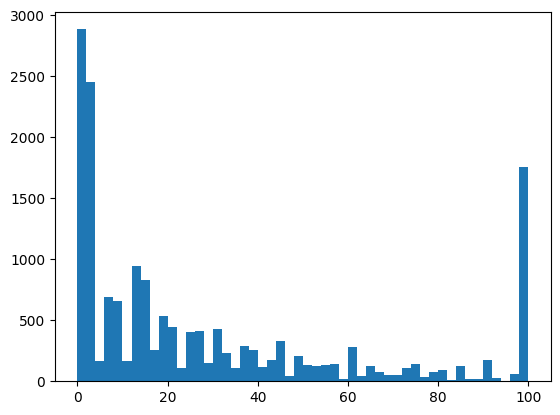

In [57]:
plt.hist(train["vote_count"].to_numpy(), bins=50, range=(0, 100))

In [35]:
train

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,vote_count
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other,48
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD,154
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,2
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD,1
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,1188113564,0.0,0.0,16610,0.0,0.000000,0.00,0.000000,0.500000,0.500000,GRDA,2
17085,4293843368,1549502620,0.0,0.0,15065,0.0,0.000000,0.00,0.000000,0.500000,0.500000,GRDA,2
17086,4294455489,2105480289,0.0,0.0,56,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other,1
17087,4294858825,657299228,0.0,12.0,4312,0.0,0.000000,0.00,0.000000,0.066667,0.933333,Other,75
